In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, LinearSegmentedColormap, SymLogNorm, ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d
import sys
import os
import warnings

helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

from petitRADTRANS.radtrans import Radtrans
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.chemistry.utils import volume_mixing_ratios2mass_fractions
from petitRADTRANS.plotlib import plot_opacity_contributions

mpl.rcParams['figure.dpi'] = 200

In [2]:
# parameters
params = np.array(['P0', 'Tint', 'CplusO', 'CtoO'])

P0s = np.array([1e6, 1e7]) # surface pressure in dyn/cm^2
Tints = np.array([50, 100, 150, 200, 250]) # internal temperature in K

CplusOs = np.array([1e-3, 3.16e-3, 1e-2, 3.16e-2, 1e-1]) #, 3.16e-1, 1e0])
CtoOs = np.array([0.1, 0.59, 1.0])

planets = np.array(['Earth', 'Io'])
#adds = ['', '_aN=1e-4', '_aN=1e-2']
#adds = ['_A=0.0', '', '_A=0.2', '_A=0.4', '_A=0.8']

folder = '../output/EqCond+Remove/'

In [3]:
def format_e_nums(num):
    num = f'{num:.2e}'.replace('0', '').replace('.e', 'e').replace('+', '')
    if num[-1] == 'e':
        num = num + '0'
    return num

def format_CtoO_float(f):
    if f == int(f):  # Check if it's a whole number
        return f"{f:.1f}"  # Format as integer if whole
    else:
        return f"{f:.10g}" # Use g format with sufficient precision.

def built_name(loop_over, P0, Tint, CplusO, CtoO, i_param=None, noCond=False, planet='Earth', add=''):
    if noCond:
        noCond = '_NoCond'
    else:
        noCond = ''

    if i_param == 0 or (i_param == None and loop_over in P0s):
        return f'{planet}_P0={format_e_nums(loop_over)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}{add}'
    elif i_param == 1 or (i_param == None and loop_over in Tints):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={loop_over}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}{add}'
    elif i_param == 2 or (i_param == None and loop_over in CplusOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(loop_over)}_CtoO={format_CtoO_float(CtoO)}{add}'
    elif i_param == 3 or (i_param == None and loop_over in CtoOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(loop_over)}{add}'
    else:
        raise ValueError('Invalid loop_over value')

def extract_data(loop_overs, i_P0=0, i_Tint=0, i_CplusO=0, i_CtoO=0, noCond=False, planet='Earth', add=''):
        
    data_dict = {
        "inds": [],
        "PTs": [],
        "nHtots": [],
        "data": [],
        "atoms": [],
        "mols": [],
        "supersats": [],
        "dusts": [],
        "mus": [],
        "convergence": [],
        "n_iter": [],
        "ntots": [],
        "eps_atoms": [],
        "dust_to_gas": [],
        "dust_vol": [],
        "lambda": [],
        "opacs": [], 
        "convective": []
    }

    for i, loop_over in enumerate(loop_overs):
        name = built_name(loop_over, P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO], noCond=noCond, add=add, planet=planet)
        #print(name)

        path = folder + name + "/Static_Conc_{var}.dat"
        conv = True
        j = 0

        while True:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                try:
                    d = np.loadtxt(path.format(var=j), skiprows=3)
                    convergence_conditions = d[-1,2] != 1e-1
                    convergence_conditions = convergence_conditions and not np.all(d[:,0] == 1.001)
                    if convergence_conditions: # if pressure is not 0.1 dyn/cm^2 (=1e-7 bar), then the simulation did not converge
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                        j -= 1
                        break
                    j += 1
                except (FileNotFoundError, UserWarning) as warn:
                    if warn.__class__ == UserWarning:
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                    j -= 1
                    break

        if i == 0:
            dimension = np.genfromtxt(path.format(var=0), dtype=int,  max_rows=1, skip_header=1)
            global n_elem, n_mol, n_dust, n_layers
            n_elem = dimension[0]
            n_mol = dimension[1]
            n_dust = dimension[2]
            n_layers = dimension[3]

            header = np.loadtxt(path.format(var=j), skiprows=2, max_rows=1, dtype=str)
            global atom_names, mol_names, dust_names
            atom_names = header[3:4+n_elem]
            mol_names = header[4+n_elem:4+n_elem+n_mol]
            dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
            dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)
        
        if j == -1:
            d = np.zeros_like(d)
            d[:,:] = np.nan

            mu = np.zeros_like(mu)
            mu[:] = np.nan

            j = np.nan
        else:
            d = np.loadtxt(path.format(var=j), skiprows=3)
            data_dict["data"].append(d)

            opac = folder + name + f'/{name}_opacities.dat'
            opac = np.loadtxt(opac, skiprows=3)
            print(opac.shape)
            lams = opac[:,1:4] # central, low, delta lambda [um]
            opac = opac[:,4:] # opacities [cm^2/g]

            convective = folder + name + f'/{name}_tp.dat'
            convective = np.loadtxt(convective, skiprows=2, usecols=6)

            try:
                mu = path[:-21] + f'vertical_mix_{j}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
            except FileNotFoundError:
                print('WARNING: ' + path[:-21] + f'vertical_mix_{j}.dat' + ' not found')
                mu = path[:-21] + f'vertical_mix_{j-1}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
                conv = False

        data_dict["PTs"].append(np.array([d[:, 2] * 1e-6, d[:, 0]]).T)  # convert pressure from dyn/cm^2 to bar
        data_dict["nHtots"].append(d[:, 1])
        data_dict["atoms"].append(d[:, 3:4+n_elem])
        data_dict["mols"].append(d[:, 4+n_elem:4+n_elem+n_mol])
        data_dict["supersats"].append(d[:, 4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
        data_dict["dusts"].append(d[:, 4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
        data_dict["eps_atoms"].append(d[:, 4+n_elem+n_mol+2*n_dust:4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_to_gas"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_vol"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem+1])
        data_dict["inds"].append(i)
        data_dict["mus"].append(mu)
        data_dict["convective"].append(convective)

        data_dict["convergence"].append(conv)
        data_dict["n_iter"].append(j)

        data_dict["lambda"].append(lams)
        data_dict["opacs"].append(opac)
    
    if not data_dict["inds"]:
        data_dict["inds"] = np.empty((1))
        data_dict["PTs"] = np.empty((1, 2))
        data_dict["nHtots"] = np.empty((1))
        data_dict["data"] = np.empty((1, 1, 4+n_elem+n_mol+n_dust+7))
        data_dict["atoms"] = np.empty((1, 1, n_elem))
        data_dict["mols"] = np.empty((1, 1, n_mol))
        data_dict["supersats"] = np.empty((1, 1, n_dust))
        data_dict["dusts"] = np.empty((1, 1, n_dust))
        data_dict["eps_atoms"] = np.empty((1, 1, n_elem))
        data_dict["dust_to_gas"] = np.empty((1, 1))
        data_dict["dust_vol"] = np.empty((1, 1))

    data_dict["inds"] = np.array(data_dict["inds"])
    data_dict["PTs"] = np.array(data_dict["PTs"])
    data_dict["nHtots"] = np.array(data_dict["nHtots"])
    data_dict["data"] = np.array(data_dict["data"])
    data_dict["atoms"] = np.array(data_dict["atoms"])
    data_dict["mols"] = np.array(data_dict["mols"])
    data_dict["supersats"] = np.array(data_dict["supersats"])
    data_dict["dusts"] = np.array(data_dict["dusts"])
    data_dict["eps_atoms"] = np.array(data_dict["eps_atoms"])
    data_dict["dust_to_gas"] = np.array(data_dict["dust_to_gas"])
    data_dict["dust_vol"] = np.array(data_dict["dust_vol"])
    data_dict["convergence"] = np.array(data_dict["convergence"])
    data_dict["convective"] = np.array(data_dict["convective"], dtype=bool)

    data_dict["lambda"] = np.array(data_dict["lambda"])
    data_dict["opacs"] = np.array(data_dict["opacs"])

    return name, data_dict

def convert(data_dict):

    for i in range(len(data_dict["data"])):
        n_tot = 10**data_dict["data"][i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        data_dict["ntots"].append(n_tot[:, None])
    data_dict["ntots"] = np.array(data_dict["ntots"])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(data_dict["atoms"]):
        atom = 10**atom
        data_dict["atoms"][i] = atom / data_dict["ntots"][i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(data_dict["mols"]):
        mol = 10**mol
        data_dict["mols"][i] = mol / data_dict["ntots"][i]

    # convert dust abundances (log(cm^-3)) to mixing ratios
    for i in range(len(data_dict["dusts"])):
        data_dict["dusts"][i] = 10**(data_dict["dusts"][i]) * data_dict["nHtots"][i][:, None] / data_dict["ntots"][i]

    data_dict["eps_atoms"] = 10**data_dict["eps_atoms"]
    data_dict["eps_atoms"] = data_dict["eps_atoms"] / (np.sum(data_dict["eps_atoms"], axis=-1)[..., None])

    data_dict["dust_to_gas"] = 10**data_dict["dust_to_gas"]

    return data_dict

In [4]:
# plan:
# - read data of specific atmosphere (incl. opacities!)
# - create prt atmo with same properties
# - plot opacity contributions of each species

In [11]:
i_P0 = 1 # i_param = 0 or 'P0'
i_Tint = 1 # i_param = 1 or 'Tint'
i_CplusO = 2 # i_param = 2 or 'CplusO'
i_CtoO = 1 # i_param = 3 or 'CtoO'
i_planet = 0 # i_param = 'planet'
#i_add = 1 # i_param = 'add'

loop_overs = Tints #['', '_aN=1e-4', '_aN=1e-2']
i_param = 'Tint'

name, data_dict = extract_data(loop_overs, i_P0=i_P0, i_Tint=i_Tint, i_CplusO=i_CplusO, i_CtoO=i_CtoO)
data_dict = convert(data_dict)

print(name)


(385, 88)
(385, 88)
(385, 88)
(385, 88)
(385, 88)
Earth_P0=1e7_Tint=250_CplusO=1e-2_CtoO=0.59


100


(10.0, 1e-07)

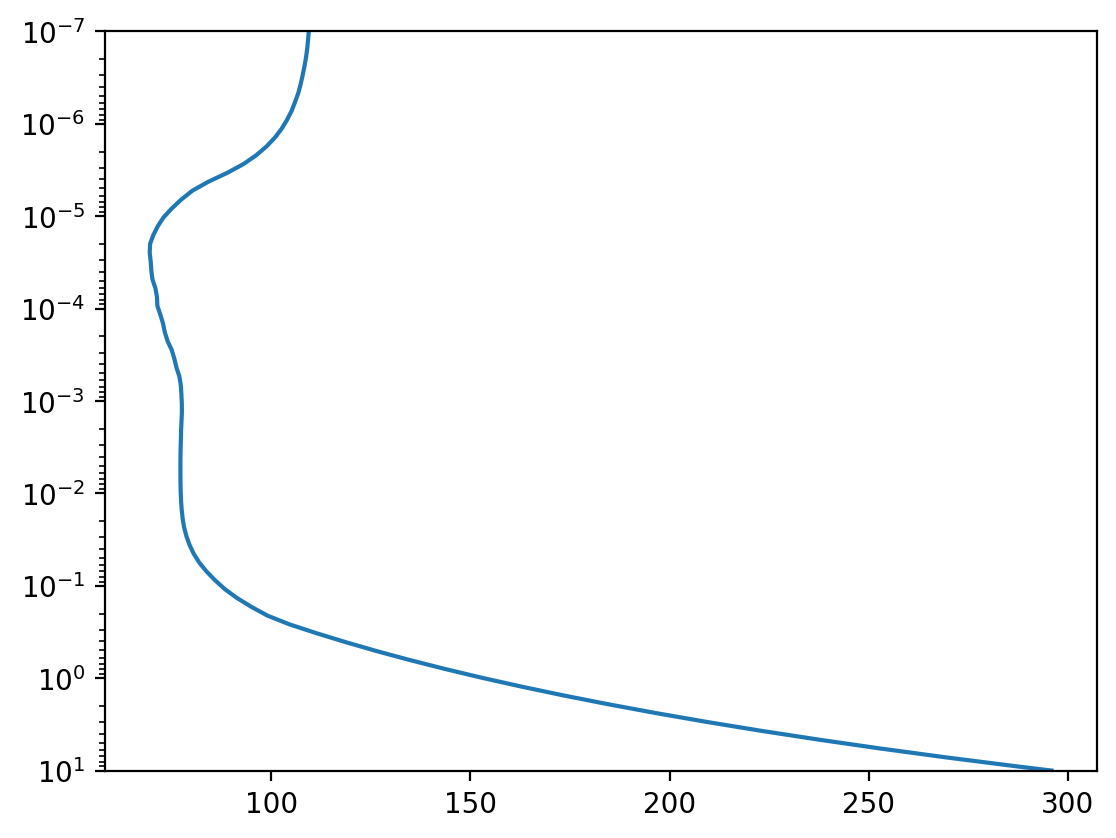

In [12]:
i = 1
print(loop_overs[i])

plt.plot(data_dict["PTs"][i][:, 1], data_dict["PTs"][i][:, 0], label='P0 = ' + str(P0s[i_P0]) + ' dyn/cm^2')
plt.yscale('log')
plt.ylim(1e1, 1e-7)


In [13]:
# construct prt atmo

i = 1

atmosphere = Radtrans(
    pressures=data_dict["PTs"][i][::-1, 0],
    line_species=[
        'H2O',
        'CH4'
    ],
    rayleigh_species=['H2'],
    gas_continuum_contributors=['H2-H2'],
    wavelength_boundaries=[1, 1000]
)

/home/moon/ddahlb/miniconda3/envs/prt312/lib/python3.13/site-packages/petitRADTRANS/_input_data_loader.py:350: UserWarning: file '1H2-16O__POKAZATEL__R1000_0.3-50mu.ktable.petitRADTRANS.h5' lacks spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lacks spectral information "


Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/moon/ddahlb/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/moon/ddahlb/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/moon/ddahlb/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully loaded all opacities


Generating temporary Radtrans object with 'line_species': 'H2O'
Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/moon/ddahlb/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/moon/ddahlb/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Generating temporary Radtrans object with 'line_species': 'CH4'
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/moon/ddahlb/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all lin

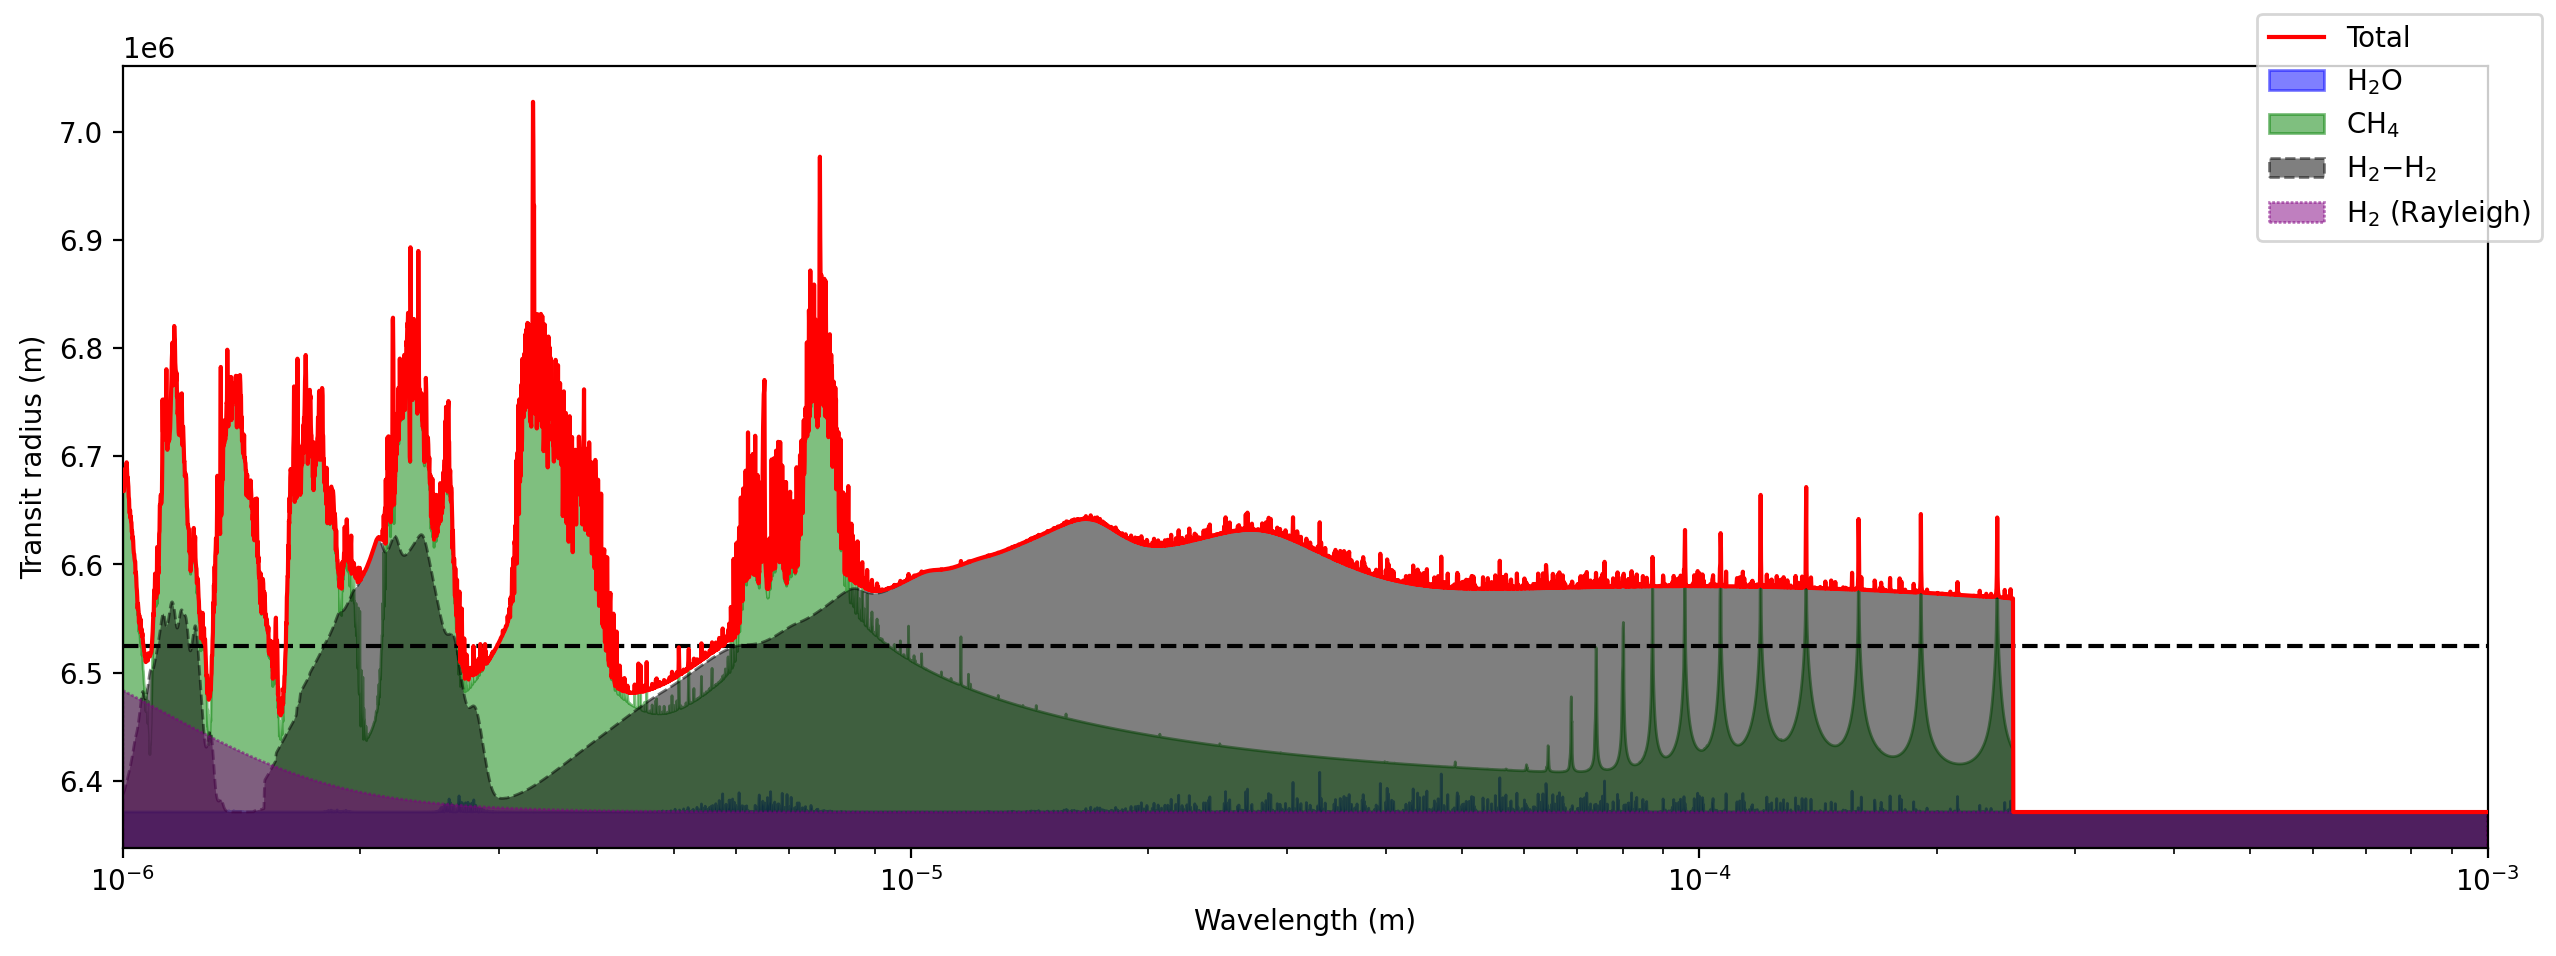

In [35]:

relevant_species = ['H2', 'H2O', 'CH4']

vmrs = data_dict['mols'][i, :, :]
vmrs = {}
for i, species in enumerate(relevant_species):
    vmrs[species] = data_dict['mols'][i, :, mol_names == species][0,:]

# convert to mmrs
mmrs = volume_mixing_ratios2mass_fractions(vmrs)

if planets[i_planet] == 'Earth':
    radius = 6.371e8 # cm
    gravity = 981.0 # cm/s^2

p_ref = P0s[i_P0]

temp = data_dict["PTs"][i][:, 1]
mmw = data_dict["mus"][i]

radius_hs_eq = atmosphere._compute_radius_hydrostatic_equilibrium(
            pressures=data_dict["PTs"][1][::-1, 0],
            temperatures=temp,
            mean_molar_masses=mmw,
            reference_gravity=gravity,
            reference_pressure=p_ref,
            planet_radius=radius,
            variable_gravity=False
        )

opacity_contributions = plot_opacity_contributions(
    atmosphere,
    mode='transmission',  # can also be 'emission'
    fill_below=True,  # if False, contributions are represented as cruves instead as a filled area
    x_axis_scale='log',  # 'linear' by default
    #include=['Total', 'H2-H2'], #, 'CH4'] #, 'H2 (Rayleigh)'],
    colors={
        'Total': 'r',
        'line_species': {
            'H2O': 'b',
            'CH4': 'g'
        },
        'rayleigh_species': {
            'H2': 'purple'
        }
    },
    #opacity_contributions=opacity_contributions,
    temperatures=temp,
    mass_fractions=mmrs,
    mean_molar_masses=mmw,
    reference_gravity=gravity,
    reference_pressure=p_ref,
    planet_radius=radius,
    variable_gravity=False
)

# plot radiative-convective boundary (assuming the bottom layers are convective)
i_layer = np.where(data_dict["convective"][i] == 0)[0][0] - 1
print(i_layer, f"{radius_hs_eq[-i_layer]:.2e}", f"{radius_hs_eq[-i_layer]-radius:.2e}")
plt.gca().hlines(radius_hs_eq[-i_layer]*1e-2, 1e-6, 1e-3, color='black', linestyle='--', label='RCB')
plt.show()

In [9]:
# plot radiative-convective boundary
i_layer = np.where(data_dict["convective"][i] == 0)[0][0] - 1
print(i_layer)

print(data_dict["convective"][i, i_layer-1], data_dict["convective"][i, i_layer], data_dict["convective"][i, i_layer+1])
print(i_layer, data_dict["PTs"][i][i_layer, 0])
print(i_layer, f"{radius_hs_eq[-i_layer]:.2e}", f"{radius_hs_eq[-i_layer]-radius:.2e}")

#plt.plot(radius_hs_eq)

18
True True False
18 0.210549
18 6.52e+08 1.53e+07
